# Simple CNN for MNIST 

Using the MNIST dataset (70 000 pictures of hand-written digits) we will train a simple CNN, which is able to predict a digit given a picture of a hand-written digit.

Adapted from: https://github.com/kenophobio/keras-example-notebook

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(1337)
torch.manual_seed(1337)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using TensorFlow backend.


Network parameters:

In [ ]:
batch_size = 128
nb_classes = 10
nb_epoch = 12

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size
kernel_size = 3

# Learning rate
learning_rate = 1.0

Prepare data into training and test set.

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# For visualization, load the raw data
(X_train, y_train), (X_test, y_test) = train_dataset.data.numpy(), train_dataset.targets.numpy(), test_dataset.data.numpy(), test_dataset.targets.numpy()
X_train, y_train = train_dataset.data.numpy(), train_dataset.targets.numpy()
X_test, y_test = test_dataset.data.numpy(), test_dataset.targets.numpy()

11493376/11490434 [==============================] - 1s 0us/step


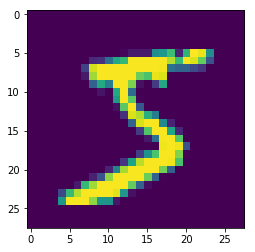

In [ ]:
plt.imshow(X_train[0], cmap='gray')
plt.title(f'Label: {y_train[0]}')
plt.show()

In [ ]:
# PyTorch handles reshaping automatically through transforms
# Data shape info
print('X_train shape:', X_train.shape)
print(f'{len(train_dataset)} train samples')
print(f'{len(test_dataset)} test samples')

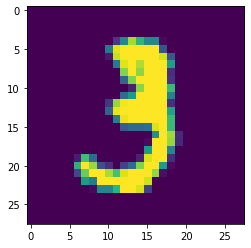

In [ ]:
plt.imshow(X_train[10], cmap='gray')
plt.title(f'Label: {y_train[10]}')
plt.show()

Build the CNN. 

In [ ]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer: 1 input channel, 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(1, nb_filters, kernel_size=kernel_size, padding='same')
        # Second convolutional layer: 32 input channels, 32 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(nb_filters, nb_filters, kernel_size=kernel_size)
        # Max pooling layer
        self.pool = nn.MaxPool2d(pool_size, pool_size)
        # Dropout layer
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Calculate the size after conv and pooling layers
        # After conv1 (padding='same'): 28x28
        # After conv2 (no padding): 26x26
        # After pooling (2x2): 13x13
        self.fc1 = nn.Linear(nb_filters * 13 * 13, 128)
        self.fc2 = nn.Linear(128, nb_classes)
    
    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        
        # Flatten
        x = x.view(-1, nb_filters * 13 * 13)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

# Create model instance
model = SimpleCNN().to(device)

# Define optimizer (Adadelta is similar to Keras default)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

# Define loss function
criterion = nn.CrossEntropyLoss()

Show a summary of the model parameters. 

In [ ]:
# Display model summary
print(model)
print("\nTotal parameters:", sum(p.numel() for p in model.parameters()))
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 26, 26)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 26, 26)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 24, 24)    9248        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 32, 24, 24)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

And now train the model and evaluate on the test set. 

In [ ]:
# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    
    return test_loss, accuracy

# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, nb_epoch + 1):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    val_loss, val_acc = test(model, device, test_loader)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

Epoch 1/12
469/469 [==============================] - 39s 82ms/step - loss: 2.3025 - accuracy: 0.1171 - val_loss: 2.3023 - val_accuracy: 0.3295
Epoch 2/12
469/469 [==============================] - 40s 86ms/step - loss: 2.3023 - accuracy: 0.1963 - val_loss: 2.3022 - val_accuracy: 0.2410
Epoch 3/12
469/469 [==============================] - 35s 75ms/step - loss: 2.3022 - accuracy: 0.2015 - val_loss: 2.3021 - val_accuracy: 0.1732
Epoch 4/12
469/469 [==============================] - 37s 79ms/step - loss: 2.3022 - accuracy: 0.1845 - val_loss: 2.3021 - val_accuracy: 0.1329
Epoch 5/12
469/469 [==============================] - 45s 96ms/step - loss: 2.3022 - accuracy: 0.1708 - val_loss: 2.3021 - val_accuracy: 0.1192
Epoch 6/12
469/469 [==============================] - 45s 96ms/step - loss: 2.3021 - accuracy: 0.1593 - val_loss: 2.3021 - val_accuracy: 0.1145
Epoch 7/12
469/469 [==============================] - 47s 101ms/step - loss: 2.3021 - accuracy: 0.1494 - val_loss: 2.3020 - val_accuracy

In [10]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0309755772928
Test accuracy: 0.9897


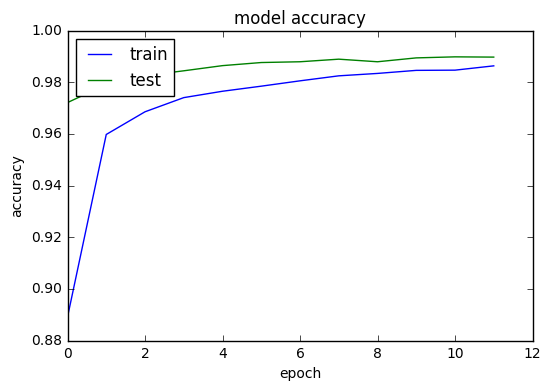

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
#https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras        

In [ ]:
#display_activation(activations, 8, 8, 1)